In [36]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

# 필요한 패키지
import os

In [2]:
# 현재 경로 확인
os.getcwd()


'c:\\Users\\admin\\Desktop\\mid_project\\MidProject\\members\\조준혁\\notebook'

In [3]:

# 상위 폴더로 이동
os.chdir('../../')

In [4]:
os.chdir(r'C:/Users/admin/Desktop/mid_project/MidProject')

In [5]:
# 현재 경로 확인
os.getcwd()


'C:\\Users\\admin\\Desktop\\mid_project\\MidProject'

# 개요

### 분석 단위 및 대상

    - 대상: 서울시 25개 자치구

    - 기간: 2023년 기준

    - 분석 단위: 자치구별 수치

### 사회불안지표 변수 구성


    - 구조적 요인:  1인가구_비율, 외국인비율, 학업중단율(중/고) - 지역 내 사회적 고립, 취약성

    - 정서적 요인:  우울감 경험률, 자살률 - 지역민의 심리적 안정도

    - 사회참여:  봉사활동 등록률 (역정규화) - 공동체 활동 부족은 불안 요인 가능

    - 기타:  이혼율 등 (선택적으로 사용) - 가족 구조 붕괴 지표


‘마계’란 은어로 범죄 등 사회 문제가 심각한 지옥 같은 지역을 판타지 소설이나 게임 등에서 흔히 등장하는 악마, 혹은 마족이 살아가는 땅 마계에 비유한 것이다.
서울특별시 25개 자치구 중 가장 ‘마계’에 어울리는 구는 어디인가? 이는 단순히 범죄 발생 건수가 많다는 것뿐만 아니라, 사회적 불안 요인(1인 가구 비율, 외국인 주민 비율, 실업률 등)이 복합적으로 열악하여 범죄와 사회 불안이 동시에 높다는 것을 의미한다. 

인구 규모 차이를 고려해 실제로 어느 구가 더 위험한지 판단하기 위해 단순 발생 건수뿐 아니라 범죄율을 볼 것이다.

- 사회적 불안 요인: 데이터에서 추출 가능한 여러 지표 중 1인 가구 비율, 외국인 주민 비율, 실업률 등을 고려했다.

- 가설 수립: 각 요인과 범죄 사이에 상관관계가 있을 것이다.
    - 1인 가구 비율이 높을수록 범죄 발생률이 높을 것이다
    - 실업률이 높은 지역일수록 범죄가 많을 것이다
    - 외국인이 많을 수록 범죄가 많을 것이다. (문화적 다양성은 사회의 응집력이 낮출 수 있다는 가정임)
    

- EDA 시각화: 자치구별 범죄와 사회 요인을 다양한 그래프로 시각화하여 분포와 상관성, 특이점을 살피고,
- 범죄 발생률 상위 지역, 각 요인별 상위 지역을 비교하고 **상관관계 그래프(산점도, 히트맵 등)**를 통해 어떤 요인이 범죄와 밀접한지 파악한다.

- ‘마계’ 정의 기준 설정: 위 분석을 바탕으로 범죄와 여러 불안 요인에서 전반적으로 높은 점수를 보이는 자치구를 ‘마계’ 후보로 선정한다. 즉 범죄 발생률도 높고 1인 가구 등 사회적 취약 지표도 높은 지역이 최종적으로 가장 ‘마계’에 가까운 지역으로 판단될 것.

In [6]:
# 데이터 불러오기
merged10_df = pd.read_csv('members/조준혁/궁극머지데이터.csv')


## 자치구별 범죄 발생 현황

- 시작하기에 앞서 인구 수를 살펴보겠다.

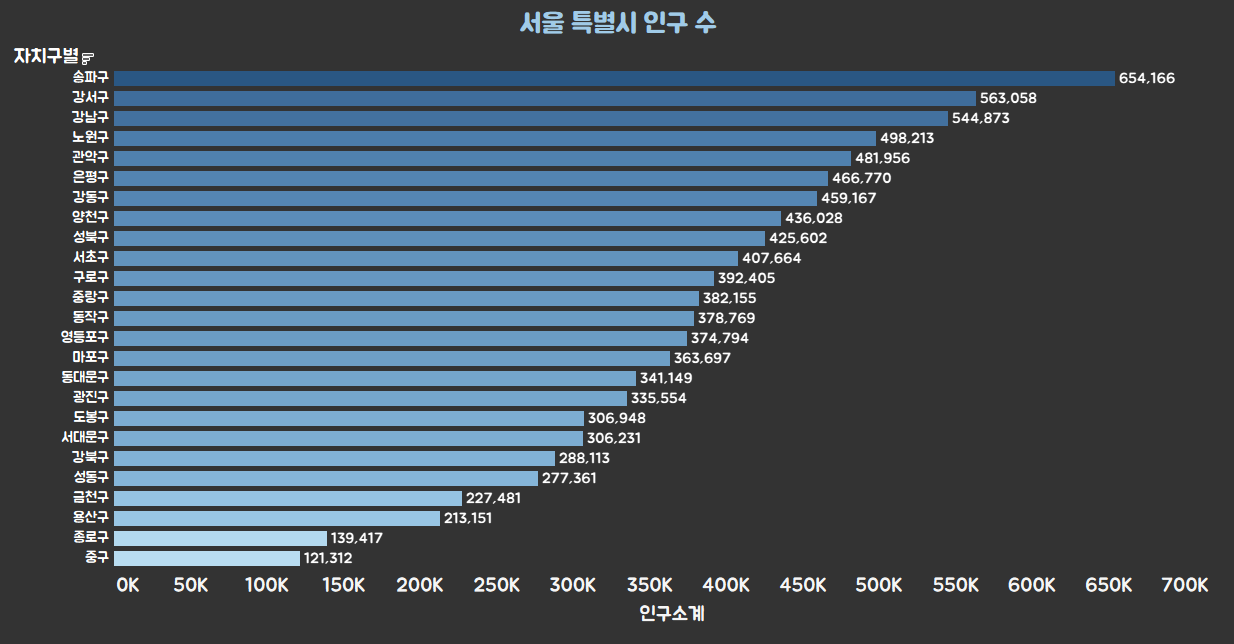

2023년 기준 송파구, 강서구, 강남구, 노원구, 관악구 순으로 인구가 많은 것을 확인할 수 있다. 

### 자치구별 범죄 발생 수준을 살펴보겠다.

- 각 구의 범죄 총 발생 건수를 비교

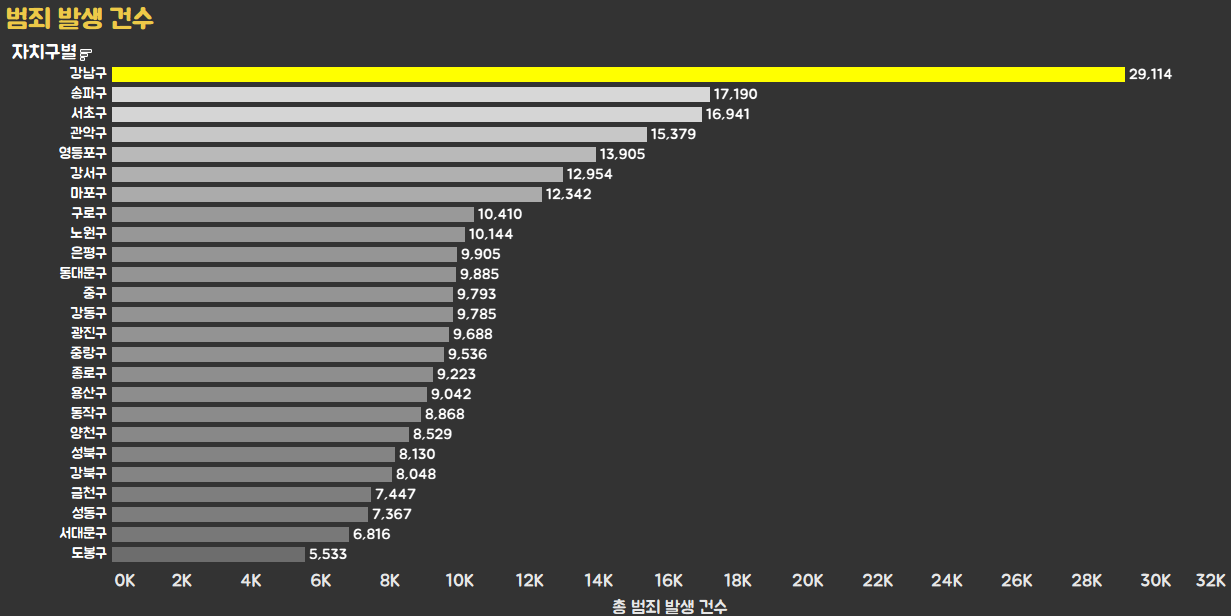

- 범죄 발생 “건수”만 보면, 인구가 많은 자치구들이 상위권을 차지한다. 특히 강남구는 연간 발생건수가 가장 많았고, 송파구, 서초구, 관악구 등도 범죄 발생건수가 높은 편이었다

- 강력범죄 발생 건수 비교

        경찰청의 범죄 발생 지역별 통계 데이터에서는 살인, 강도, 강간, 강제추행, 기타강간강제추행, 방화를 묶어 강력범죄라고 정의한다. 
        일반적으로 폭행과 절도를 묶어 5대 범죄, 5대 강력범죄라고 부르기도 하지만 경찰청에서는 상해, 폭행, 감금 등을 폭력범죄로 분류하며 
        절도는 절도범죄로 분류한다. 

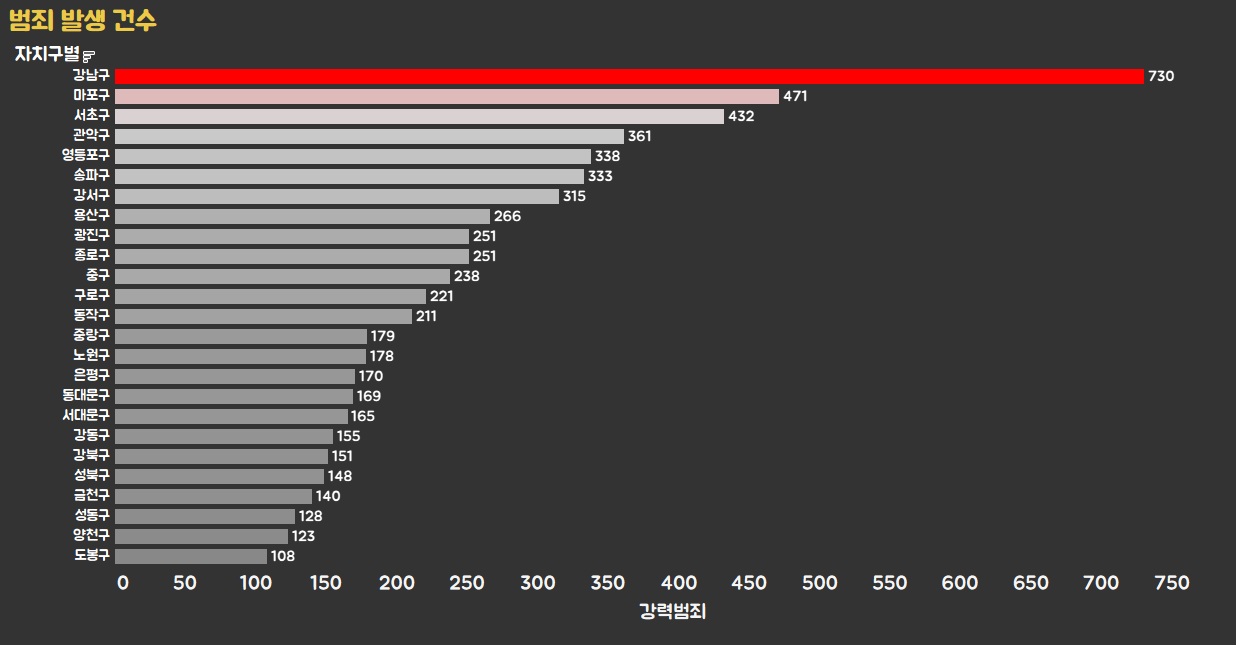

2023년 데이터 기준 강남구의 강력범죄 발생 건수는 730건으로 최다 수준이다. 이는 강남구의 인구가 많기 때문으로 추측할 수 있다
반면 마포구는 인구 수가 상대적으로 많지 않지만 강력범죄 건수가 매우 많다. 

- 범죄 발생 “률”(인구 대비 발생률)을 보면 결과가 다소 다르다

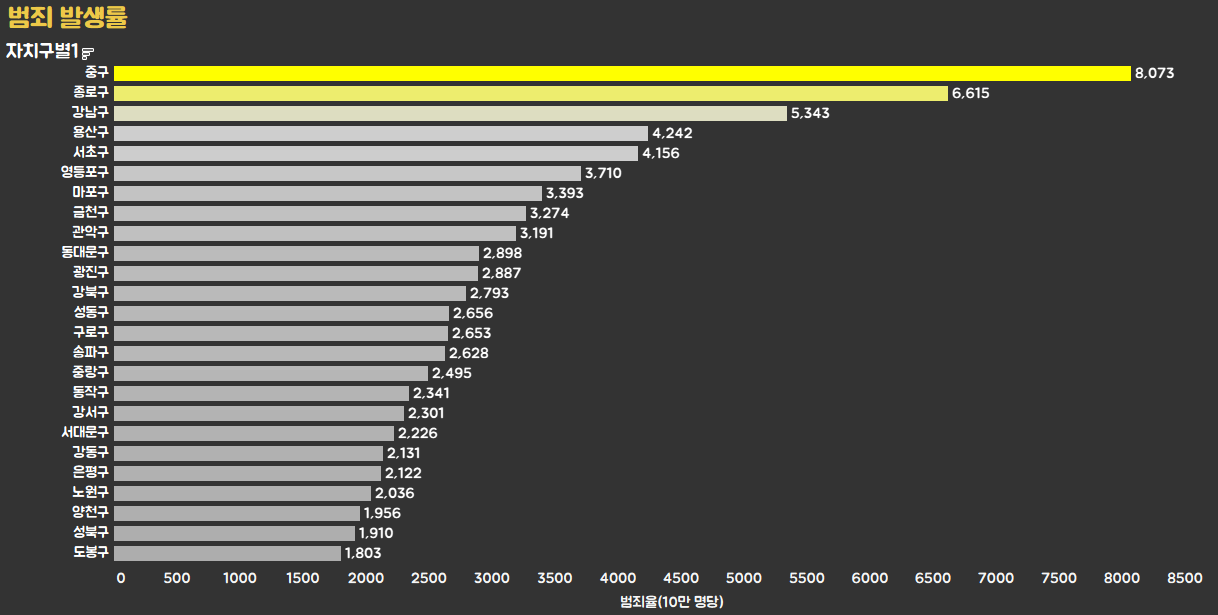

인구 10만 명당 범죄 발생률이 가장 높은 곳들은 중구, 종로구 등의 도심지역으로 나타났다.
노원구는 발생 건수는 중상위권이지만 인구가 많아 10만 명당 범죄율은 비교적 낮게 나왔다
송파구는 발생 건수는 많으나 인구대비 범죄율은 중하위 수준에 그쳤다. 

범죄 “발생건수”만 볼 경우 강남구가 최다 등 인구 규모 영향이 컸다. 그러나 **“발생률”**을 보면 중구, 종로구 등이 더 두드러졌다. 따라서 절대 발생 건수와 인구 대비 발생률을 모두 고려해야 지역의 위험성을 제대로 평가할 수 있을 것이다.

# 구조적 요인 (1인가구_비율, 외국인비율, 학업중단율(중/고))

### 지역 내 사회적 고립, 취약성

### 1인 가구 수와 범죄

가설: 가족보다 1인 가구가 많은 지역일수록 범죄에 취약할 가능성이 높다. 1인 가구는 공동체 감시 약화, 사회적 고립 등의 이유로 범죄 표적이 되기 쉽고, 특히 청년 1인 가구 밀집 지역에서 범죄가 증가한다는 보도도 있다. 

https://www.newsis.com/view/NISX20250514_0003175378#:~:text=%5B%EB%8B%A8%EB%8F%85%5D%EA%B5%90%EC%A0%9C%ED%8F%AD%EB%A0%A5%C2%B7%EC%8A%A4%ED%86%A0%ED%82%B9%E2%80%A61%EC%9D%B8%EA%B0%80%EA%B5%AC%20%EB%B0%80%EC%A7%91%20%27%EC%98%81%EB%93%B1%ED%8F%AC,%EC%A4%91%20%EA%B4%80%EC%95%85%EA%B5%AC%EB%8A%94%20%EC%84%9C%EC%9A%B8%2025%EA%B0%9C

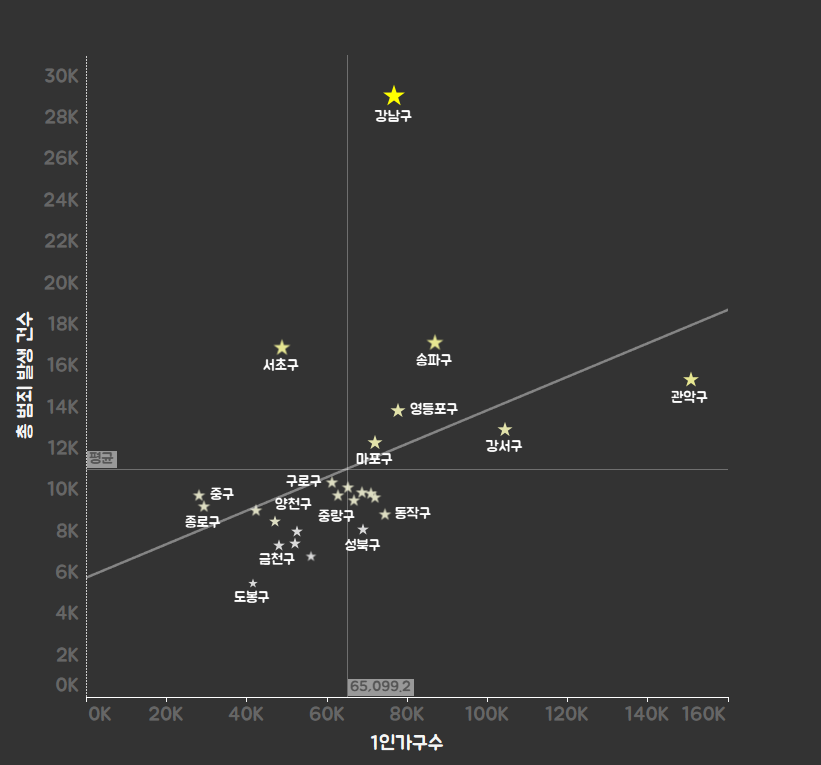

각 자치구들의 1인 가구 수 와 총 범죄 발생 건수의 관계를 나타낸 산포도 그래프이다. 
회귀선은 완벽한 선형관계는 아니지만 1인 가구 수가 증가할수록 강력범죄 발생 건수도 다소 증가하는 경향이 있음을 나타낸다
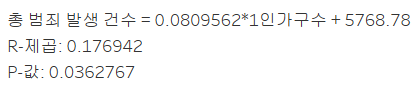
- 결정계수 R제곱은 0.1769, p-value는 0.036으로 통계적으로 유의미함을 알 수 있다.
평균을 기준으로 참조선을 그리면 4사분면으로 나눌 수 있다.




강남구, 관악구, 송파구, 영등포구, 강서구:
- 이 구역의 자치구들은 상대적으로 1인 가구도 많고 범죄도 많이 발생하는 특징이 있다
- 특히 강남구는 범죄 발생 건수가 회귀선의 예상치보다도 훨씬 더 높다.


동작구, 성북구, 중랑구 등: 
- 1인 가구 수는 많지만 범죄발생건수는 낮다. 즉 범죄 억제력이 있는 1인 가구 밀집 지역일 가능성이 있다.


서초구 : 
- 1인 가구 수는 적은데도 불구하고 범죄 발생 수가 많은 편이다.
- 소득 수준, 유동 인구, 상업시설 밀집도 등 다른 요인이 작용할 수 있다.
라는 점을 알 수 있다. 


도봉구, 금천구, 종로구, 성동구: 
- 전반적으로 위험도 낮고 주거 안정성이 높은 구역으로 해석될 수도 있다.



강남구는 회귀선 기준으로 명백한 이상치이며 예상되는 강력범죄 수보다 훨씬 높다.
사회적 불안 요인이나 유동 인구, 유흥가 밀집 등 외생 변수 고려할 필요가 있다.

관악구는 1인 가구 수가 매우 많지만, 범죄 수는 예상보다 낮다.
1인 가구 수가 많다고해서 반드시 위험한건 아님을 보여준다. 

- 범죄의 전체 수 말고 강력범죄에 대해서도 그래프를 그려본다. 
이번에는 각 자치구들의 1인 가구 수 와 강력범죄 발생 건수의 관계를 나타낸 산포도 그래프이다.


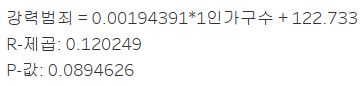

p-value가 높다. 산점도 상에서는 약한 양의 관계처럼 보여도 실제로는 우연히 나타난 패턴일 가능성이 높다.
회귀선 자체는 시각적으로 의미는 있지만, 통계적으로 의미 있는 설명력을 가지지 않으며
이 변수만으로는 강력범죄를 설명하기 어렵고, 다른 설명 변수가 필요하다. 

### 단순 범죄 발생 건수는 자치구의 인구수의 영향을 받을 수 밖에 없다.


앞의 범죄 발생 현황에서도 알 수 있듯 범죄 건수는 인구 많은 자치구가 불리하다. 
예를 들어 인구 10만에 100건 발생하면 범죄율은 0.1%이다.
하지만 인구 5만에 70건 발생하면 0.14%로 실제로 더 위험하지만 건수만 보면 작아보인다.

따라서 자치구의 인구수 대비 범죄율 및 각 변수들을


In [7]:

merged10_df['정신의료기관비율'] = (merged10_df['정신의료기관수'] / merged10_df['인구소계']) * 100000  # 10만명당
merged10_df['병상 수 비율'] = (merged10_df['정신의료기관 병상 수'] / merged10_df['인구소계']) * 100000  # 10만명당

merged10_df['인구 비율'] = (merged10_df['인구소계'] / 9386034)* 100

merged10_df['청소년비행_비율'] = (merged10_df['청소년비행 신고'] / merged10_df['인구소계']) * 100000  # 10만명당
merged10_df['1인가구_비율'] = (merged10_df['1인가구수(남녀총합)'] / merged10_df['가구-계 (가구)']) * 100
merged10_df['1인가구_비율(여성)'] = (merged10_df['1인가구수(여자)'] / merged10_df['가구-계 (가구)']) * 100
merged10_df['1인가구_비율(남성)'] = (merged10_df['1인가구수(남자)'] / merged10_df['가구-계 (가구)']) * 100
merged10_df['외국인비율'] = (merged10_df['등록외국인 소계'] / merged10_df['인구소계']) * 100


merged10_df['총범죄율'] = (merged10_df['총 범죄 발생 건수'] / merged10_df['인구소계']) * 100000 # 10만명당
merged10_df['강력범죄율'] = (merged10_df['강력범죄'] / merged10_df['인구소계']) * 100000 # 10만명당


- 이런 방식으로 10만 명당 범죄 건수로 정규화하여 데이터에 담아두었다. 

## 비율을 이용한 데이터분석 시작 
인구 크기에 따른 착시 제거, 사회구조적 특징 비교 가능(1인 가구 수는 적지만 비율은 높은 구가 있을 수 있다)이라는 이유 등으로 이제부터는 비율화된 데이터들을 사용해 분석을 해보겠다.

### 1인가구 비율과 범죄율을 이용한 분석

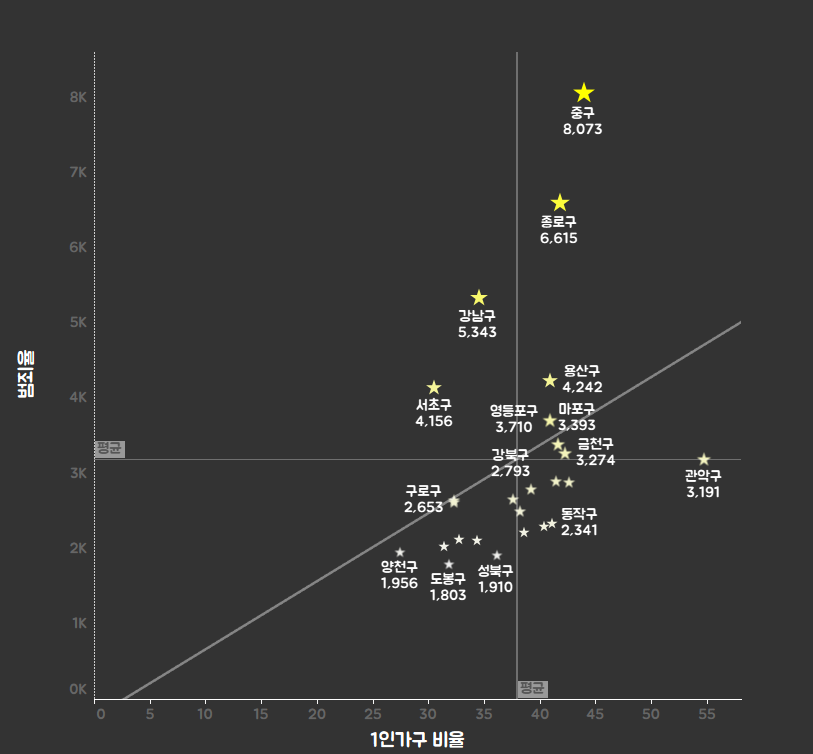

각 자치구들의 1인 가구 비율과 범죄 발생율의 관계를 나타낸 산포도 그래프이다.
회귀선의 경우 단순회귀직선이 적용되어있다

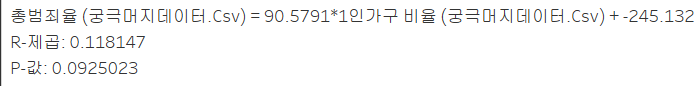

p-value가 높아 "1인 가구 비율이 증가하면 총범죄율도 증가한다"는 관계가 현재 데이터 상에서 우연히 나타났을 가능성을 배제할 수 없다.



결정계수인 R제곱도 너무 낮아 1인 가구 비율만으로 범죄율을 설명하기 어렵다
하지만 1인 가구 비율이 높을수록 범죄율이 높아지는 경향은 있다. 
단순히 1인 가구가 많아서 범죄가 많은 게 아니라,
관광지·유동 인구·유흥시설 밀도 등 외생적 요인이 강하게 작용했을 가능성이 있다.

- 지수함수 형태의 회귀곡선을 적용하면 어떻게 될까?

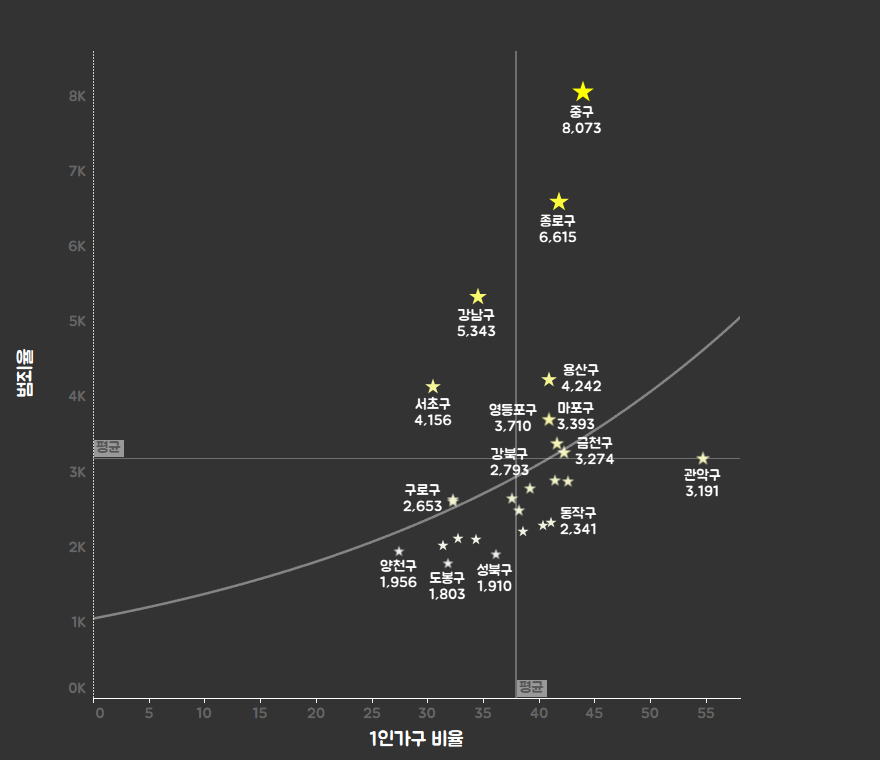

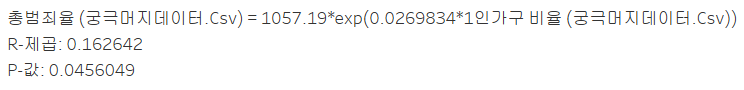

지수함수 형태의 회귀곡선을 적용했더니 p-value가 0.05 미만으로 통계적으로 유의해졌으며 단순 선형 회귀보다 설명력이 향상되었다. 
곡선은 천천히 증가하다가 급격히 상승하는 모습을 보여준다.
다만 중구(8,073), 종로구(6,615), 강남구(5,343)의 경우 곡선에서 너무 멀리 떨어져 이상치에 가깝다

 

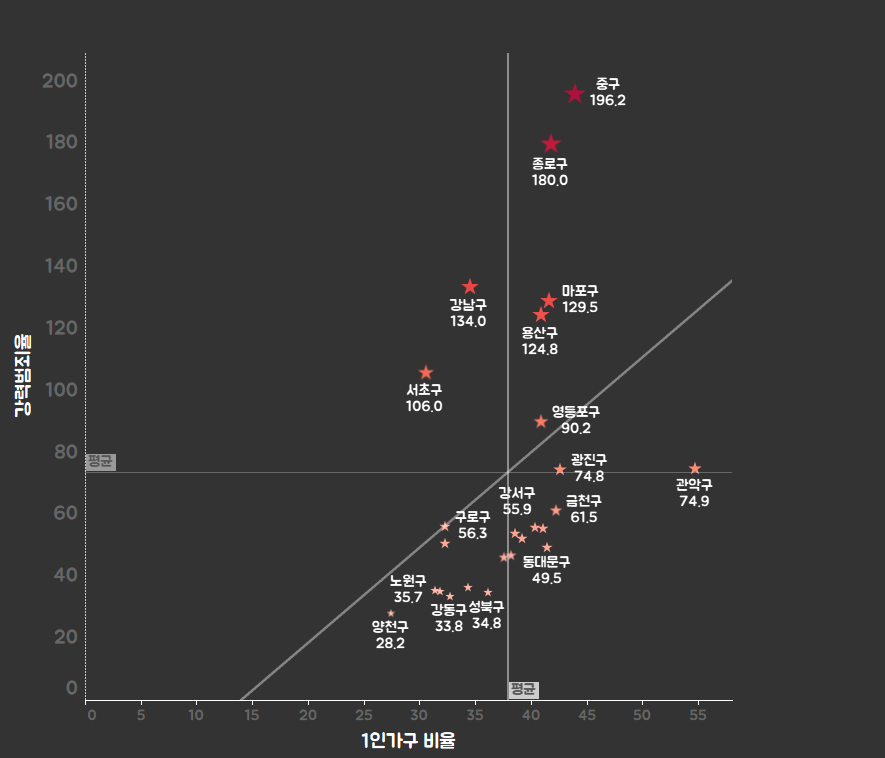

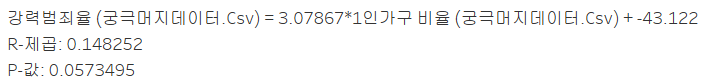

1인 가구 비율과 강력범죄율 사이의 관계를 분석한 회귀직선와 산점도이다.
p-value는 유의수준 0.05보다는 크지만 아주 약한 유의성이 있다. 

회귀선을 보면 우상향으로 양의 상관관계가 존재한다고 볼 수 있다.

- 단순선형회귀가 아니라 곡선 형태의 지수함수 회귀 모델을 적용하면

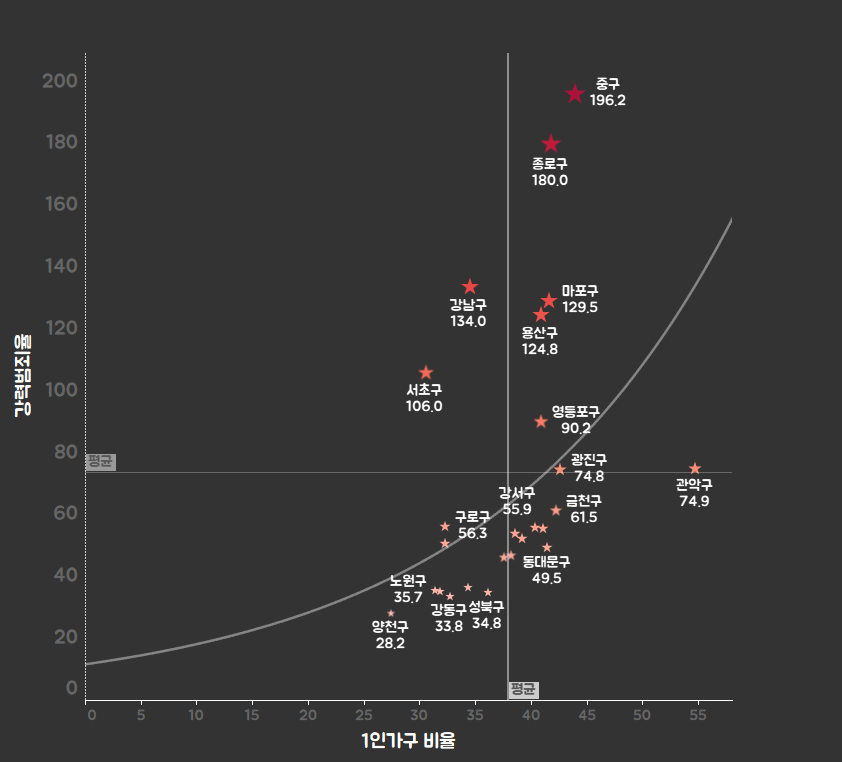

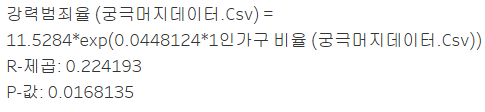

설명력이 명확히 향상되었고, p-value가 감소해서 통계적으로 유의한 모델로 인정 가능한 선이 되었다.

이 점은 1인 가구 비율이 증가할수록 강력범죄율이 기하급수적으로 증가한다는 점을 보여줄 수 있다.

#### 인사이트

1인 가구 비율이 특정 임계점(예: 40% 이상)을 넘을 때, 범죄율이 급증할 수 있다는 점을 보여주며 정책적 개입 필요성을 보여준다. 

### 외국인비율과 범죄율

선형 회귀

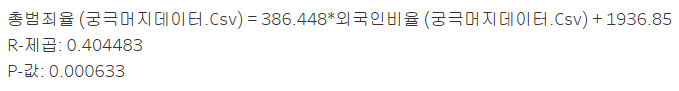

지수 회귀

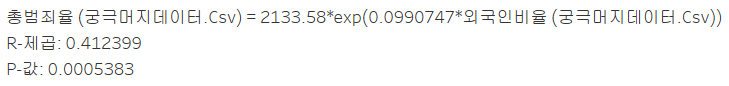

3차 다항 회귀 모델

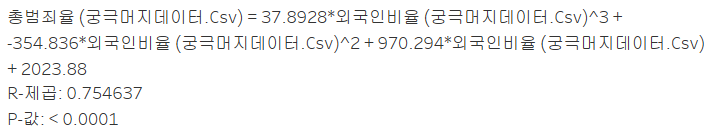

다항회귀가 가장 설명력이 높고 , pvalue를 봤을 때 통계적으로도 매우 유의하다

다항회귀선을 추가한 자치구별 외국인비율과 전체 범죄율을 본 산점도 그래프

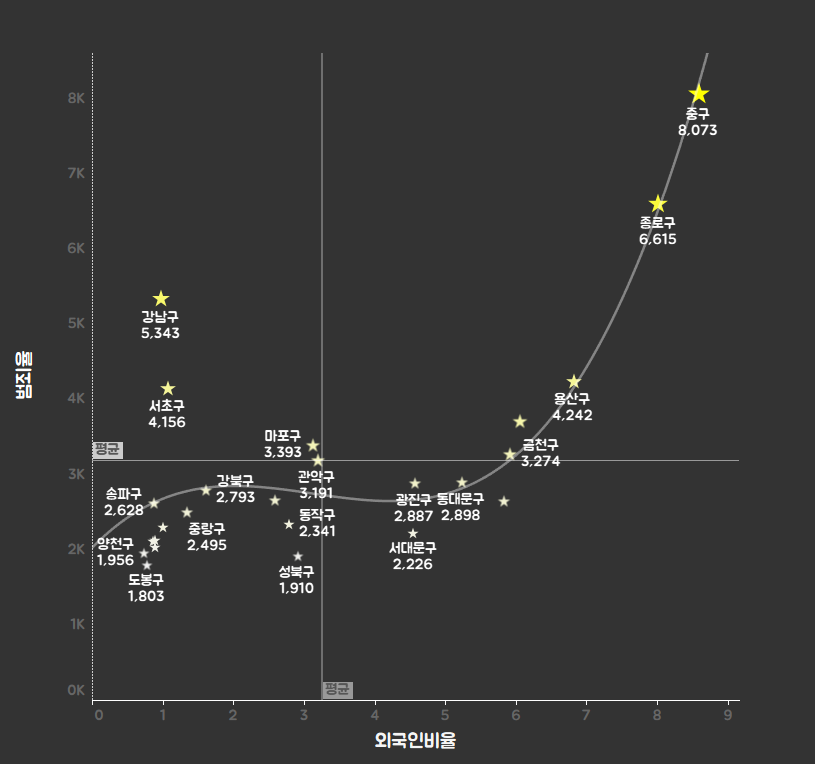

외국인 비율이 낮을 때 (0~2%) : 총범죄율은 2,000~3,000대에서 유지된다. 이 구간에서는 외국인 비율이 총범죄율에 크게 영향을 주지 않는다.

외국인 비율이 3~5%로 증가할 때: 곡선이 일시적으로 완만하거나 하강한다.

외국인 비율이 6% 이상: 이 구간부터는 외국인 밀집도가 사회적 취약 요인 또는 유동 인구/관광객/상권 밀도 등과 복합적으로 작용해 범죄율이 급증한다

강남구와 서초구는 예측된 범죄율보다 훨씬 많은 범죄가 발생했으며 이 자치구들에서는 외국인 비율이 총범죄율을 설명하지 못한다. 
강남/서초는 유흥가 밀도, 경제적 격차, 고소득층 대상 범죄, 유동 인구 등 다른 설명 변수가 필요할 것 같다.

#### 강력범죄율과의 비교

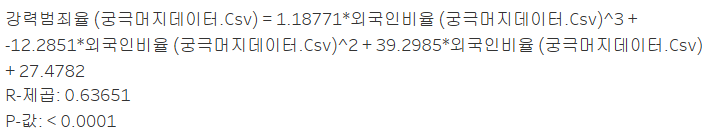

강력범죄율도 마찬가지로 다항회귀가 가장 설명력이 높고 p-value의 값도 통계적으로 매우 유의했다.

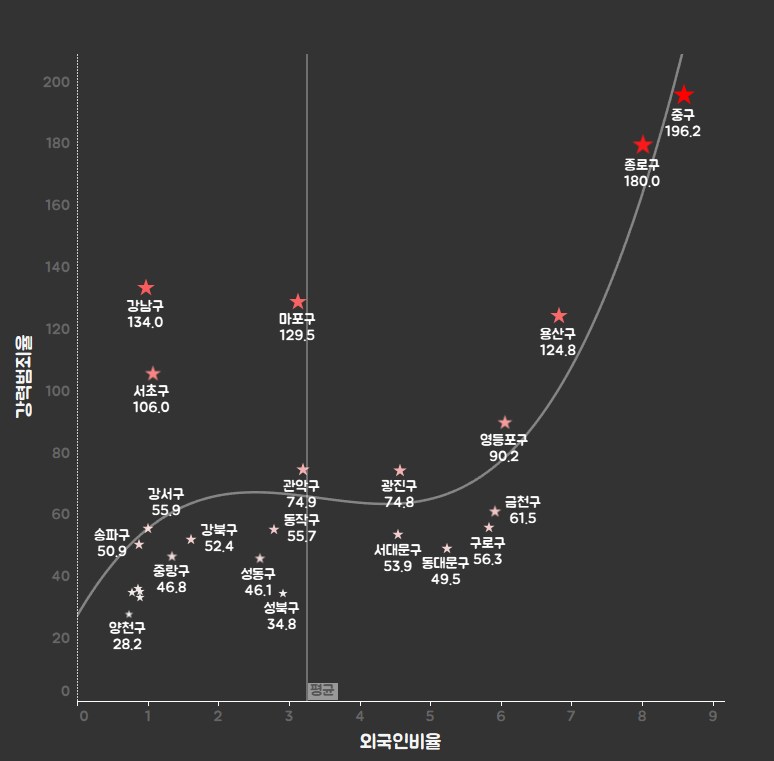

3차 다항 회귀곡선 구조가 전체 범죄율과 매우 유사하다. 
외국인 비율이 6% 이상일 때 급격한 증가가 나타나는데 
- 전체 범죄율과 달리 예측범위 내에 있던 마포구의 경우 외국인 비율에 비해 강력범죄율이 높다.
이 경우 홍대 상권, 유흥시설, 유학생/단기체류 외국인, 고밀도 유동 인구를 살펴볼 필요가 있다.

#### 인사이트

외국인 비율이 높을수록 (특히 6% 이상) 총범죄율과 강력범죄율 모두 급격히 상승한다.
중구, 종로구, 용산구는 정책적 치안 강화 대상이 되어야 할 것이다.
강남구·서초구는 외국인 변수로 설명되지 않는 이상치이며 유흥업소, 고소득층 대상 범죄, 야간 활동 밀도 등 다른 변수가 필요하다.
마포구는 외국인 비율이 중간이지만 지역 특성상 외국인 상주 인구보다 유동 외국인의 영향이 클 가능성이 있다.

### 학업중단율(중/고)

학업중단율 = 학업 중단자 수 ÷ 학생 수 × 100

학업중단율이 높으면 사회적 고립도가 높아져 범죄를 저지를 가능성이 높아질 것이라는 가설 

#### 중학교 학업중단율

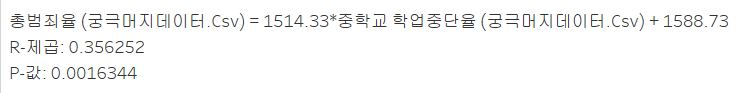

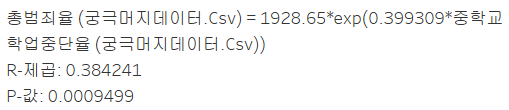

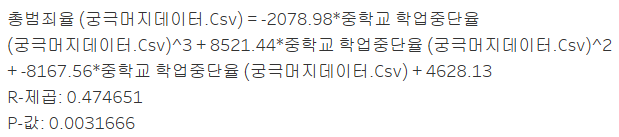

다항식의 경우가 데이터를 가장 잘 설명한다고 말할 수 있지만 

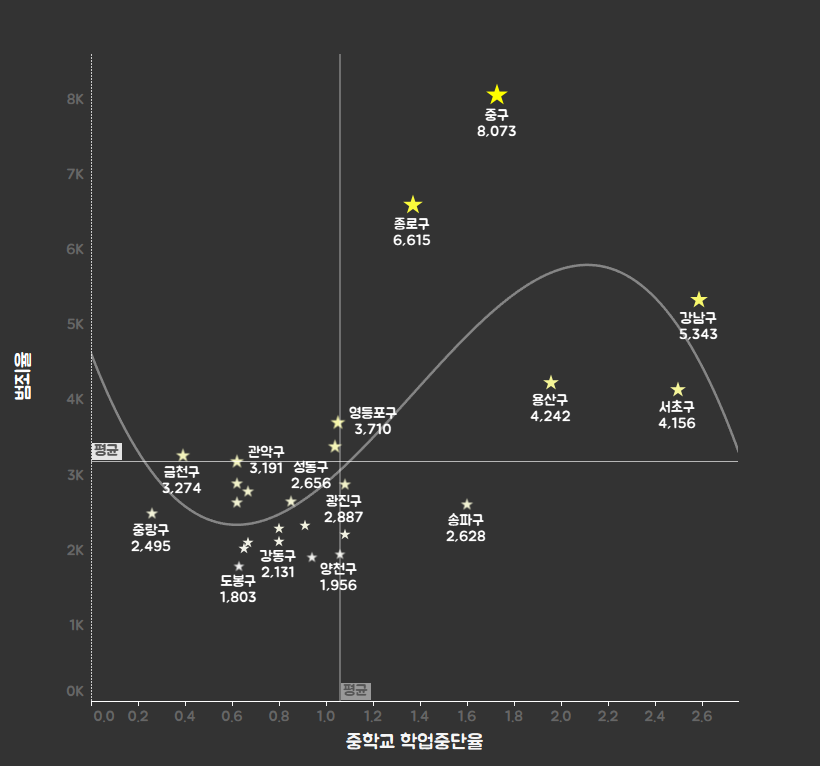

다항식으로 분석할 경우 설명력은 가장 높고 p-value도 유의하지만, 2.2% 이후 학업중단율이 높아질수록 범죄율이 오히려 낮아진다는 해석이 상식적으로 어긋나게 된다.

3차 다항회귀 모델은 통계적으로 유의하며 설명력도 높았지만, 학업중단율이 일정 수준 이상일 때 오히려 범죄율이 감소하는 결과는 사회적 현실과 부합하지 않으므로, 이에 따라 설명력은 다소 낮지만, 해석 가능성이 높은 지수함수 모델을 분석에 채택하겠다.

**지수함수**

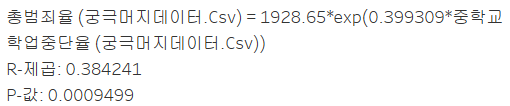

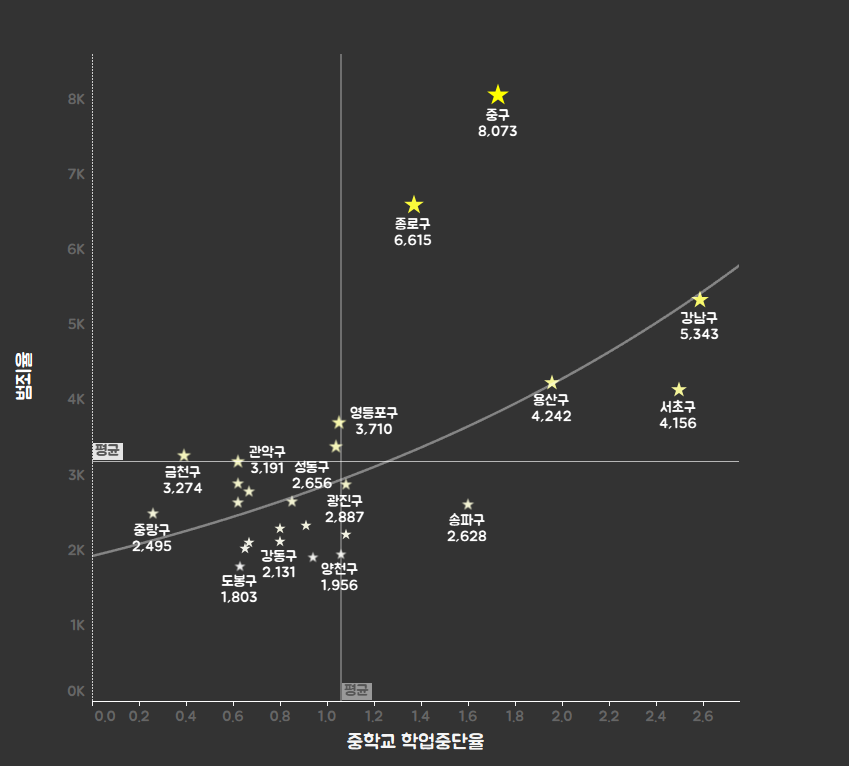

지수함수의 경우 인과 해석이 쉽고, R²도 나쁘지 않다

중학교 학업중단율을 X축으로, 총범죄율을 Y축으로 나타낸 지수 회귀 추세선을 포함한 산점도이다.

 - 학업중단율이 증가할수록 총범죄율이 급격히 증가한다는 것을 보여준다. 

- 학업중단율이 1.06% 보다 낮은 대부분 자치구는 범죄율이 낮은 편이다.
- 상위권 2%이상의, 대표적으로 강남구, 서초구는 학업중단율도 높고 범죄율도 높다 
- 송파구는 학업중단율은 높은데 범죄율은 낮은 이상치일 가능성이 있고
- 중구, 종로구는 학업중단율에 비해 범죄율이 매우 높다. 다른 요인(유동인구, 유흥시설 등)을 의심할 수 있다.

#### 강력범죄율의 경우

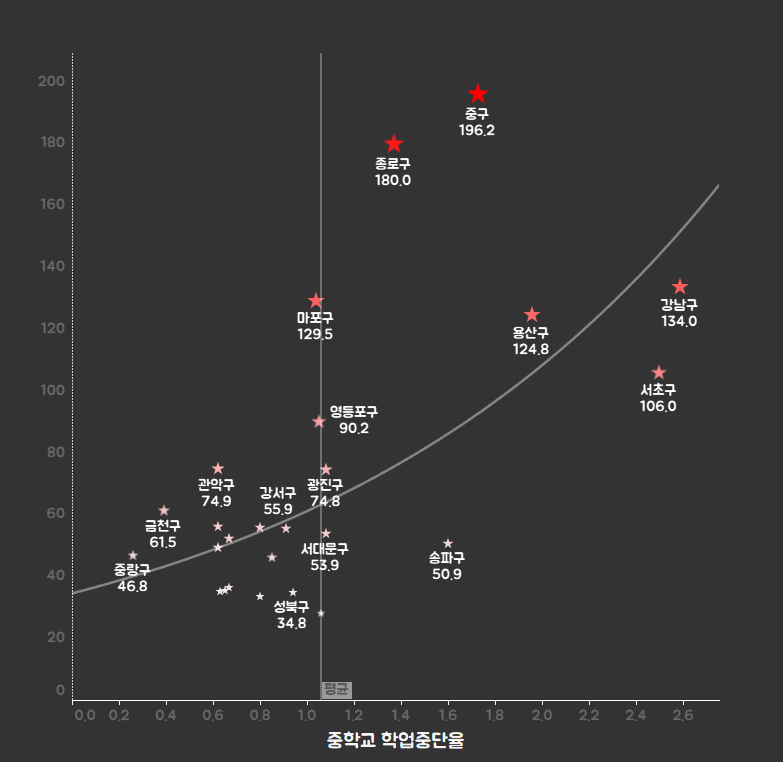

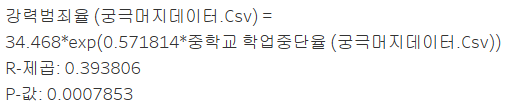

강력범죄율도 전체 범죄율과 유사한 정도로 설명된다는 점에서 학업중단율은 전반적인 범죄 발생에 구조적 영향을 주는 변수일 수 있다.
이는 청소년기 이탈의 결과가 단순한 교육 손실이 아니라 사회 전반의 위험으로 확장될 수 있음을 보여준다.

#### 고등학교의 경우는 어떨까

고등학교는 단순회귀가 더 잘 설명해서 단순회귀선을 추가했다.

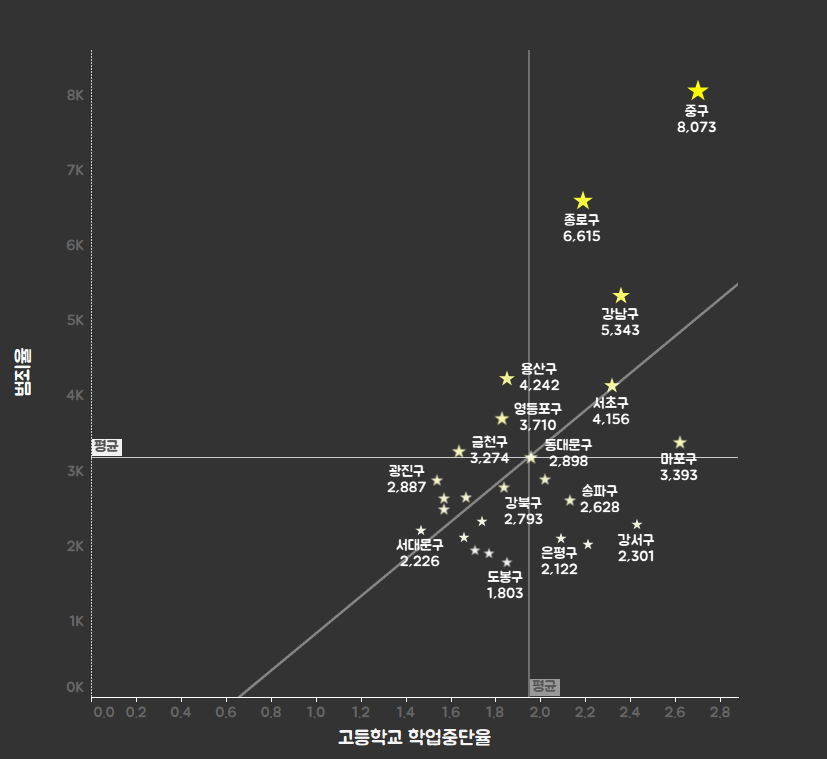

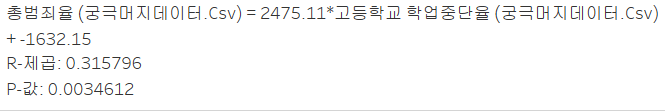

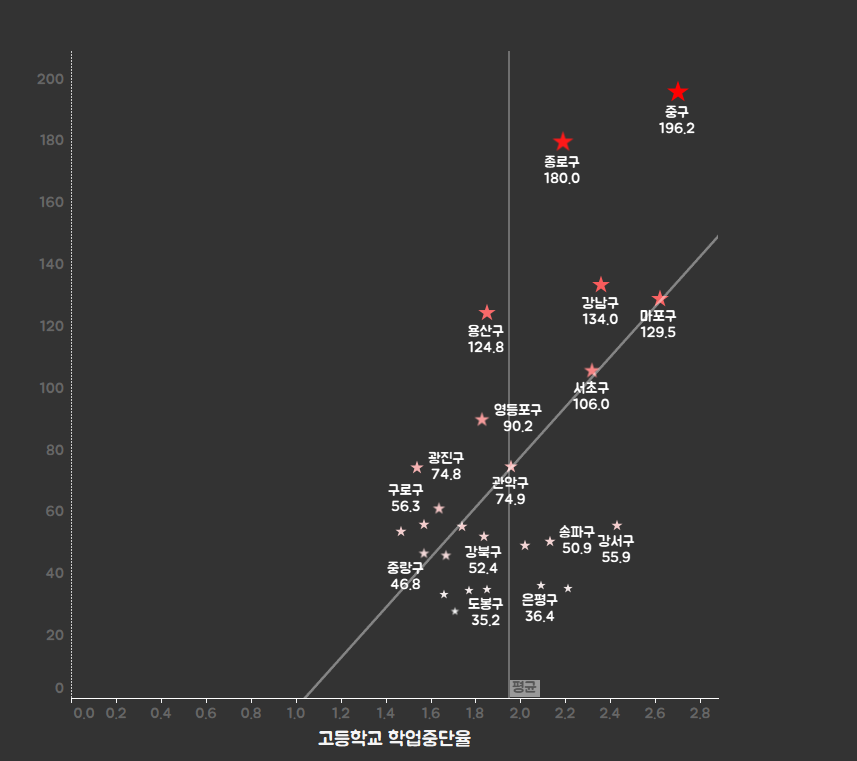

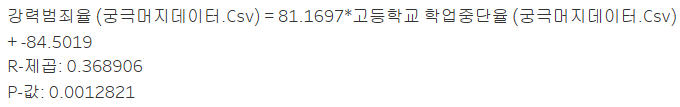

고등학교 학업중단율 역시 범죄율, 강력범죄율과 양의 상관관계가 존재하며 p-value 역시 통계적으로 유의함을 보여준다.
고등학교 학업중단율 강력범죄율의 결정계수는 약 0.37로 총범죄율보다 조금 더 높은 설명력을 보여준다. 고등학교 학업중단율은 강력범죄에 더 밀접한 영향을 줄 수 있다

#### 인사이트

학업중단 예방 정책은 단순히 교육 문제가 아니라 공공안전 강화 정책의 일부로 간주될 수 있다.

하지만 고등학교 학업중단율의 결정계수가 0.3~0.37 수준이므로, 다른 변수들(예: 외국인 비율, 실업률 등)을 함께 고려하는 다중회귀 모델 또는 종합 지표가 필요하다.

# 정서적 요인(우울감 경험률, 자살률)

## 우울감 경험률

성인인구 중 최근 1년 동안 연속적으로 2주 이상 일상생활에 지장이 있을 정도로 슬프거나 절망감 등을 느낀 사람의 비율

우울감이 높으면 사회불안이 높을 것이다는 가정

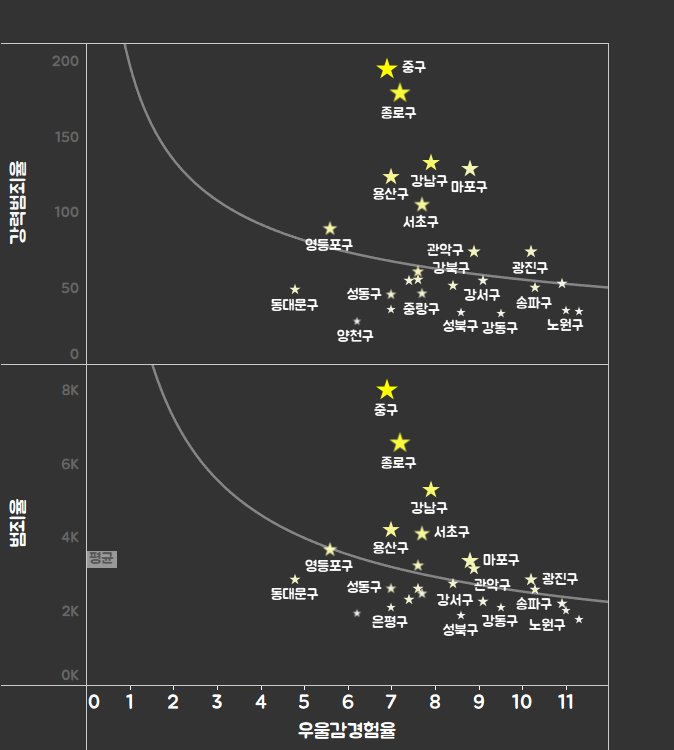

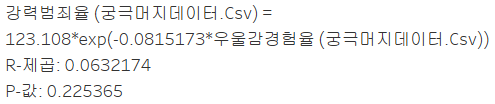

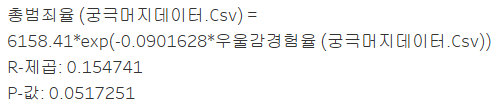

우울감 경험률이 높다고 해서 강력범죄율이나 총범죄율이 높아지는 경향은 없었다. 오히려 우울감이 높으면 범죄율이 떨어지는 약한 음의 상관을 보여주었는데 R제곱의 값도 너무 낮으며 p-value가 너무 높아 통계적으로도 유의하지 않다
이 변수(우울감 경험률)는 현재 범죄 발생을 설명하거나 예측하는 데에 적절하지 않은 것 같다.

## 자살률

### 범죄율과 비교

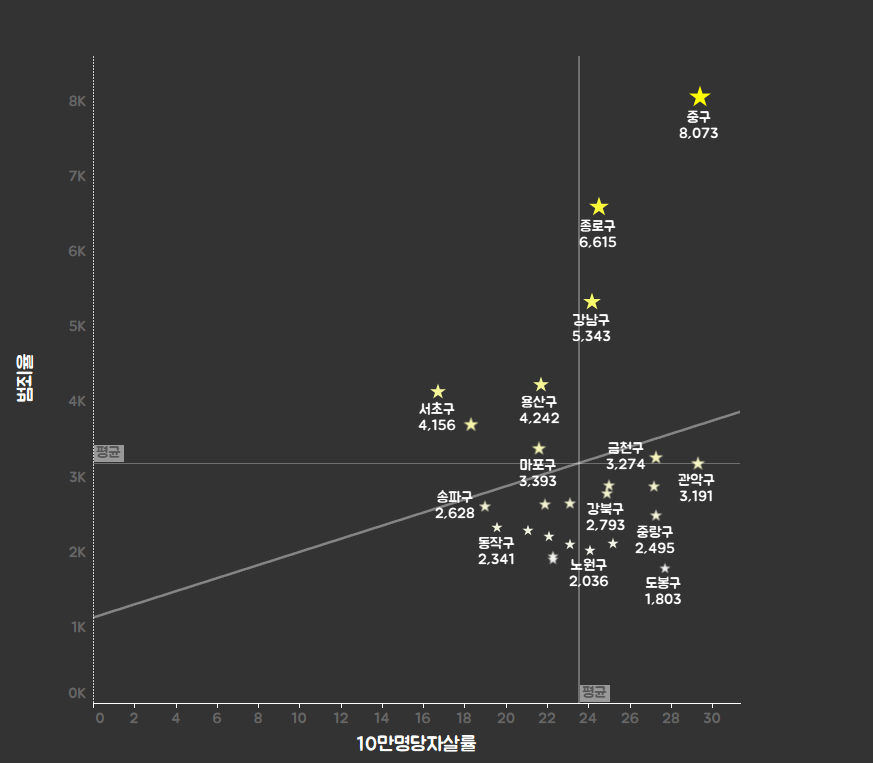

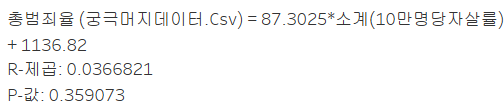

매우 약한 상관, 통계적으로 유의하지 않다.

### 강력범죄율과 비교

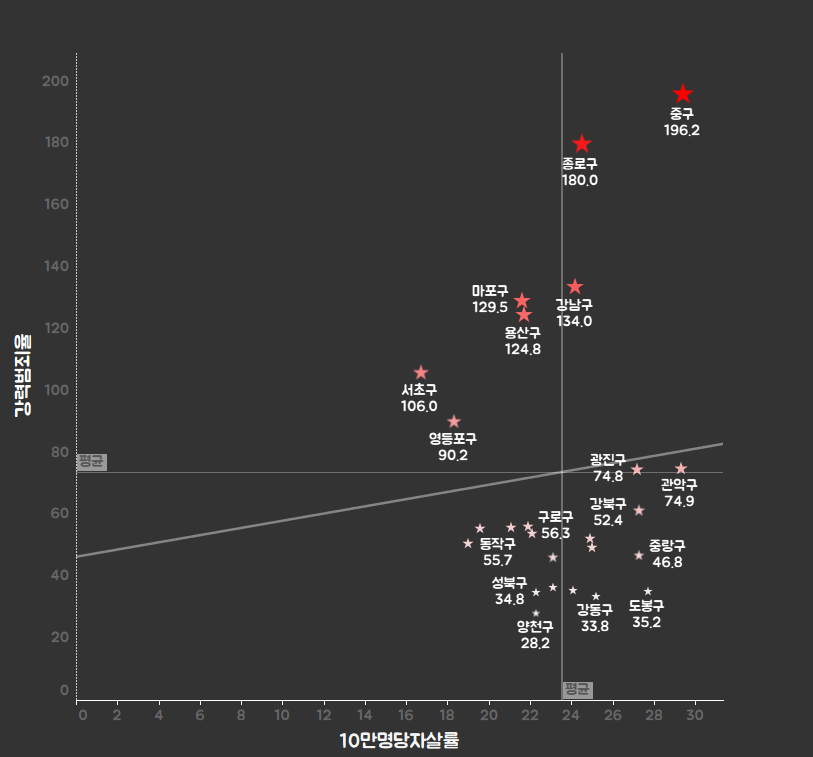

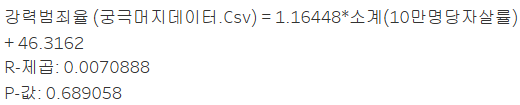

해당 변수는 통계적으로 유의하지 않으며, 본 회귀모형에서 유효한 설명변수로 보기 어렵다.

#### 10만명당 자살률 결론

R² 값이 0.007 ~ 0.037 수준으로, 설명력이 극히 낮고,
p-value도 매우 높아 범죄와의 직접적인 관련성이 없는 것 같음

# 사회참여(봉사활동 등록률)

## 봉사활동 등록률과 범죄율

봉사활동 참여율이 높은 지역일수록 사회적 연대감이 강하고, 범죄율은 낮을 것이다

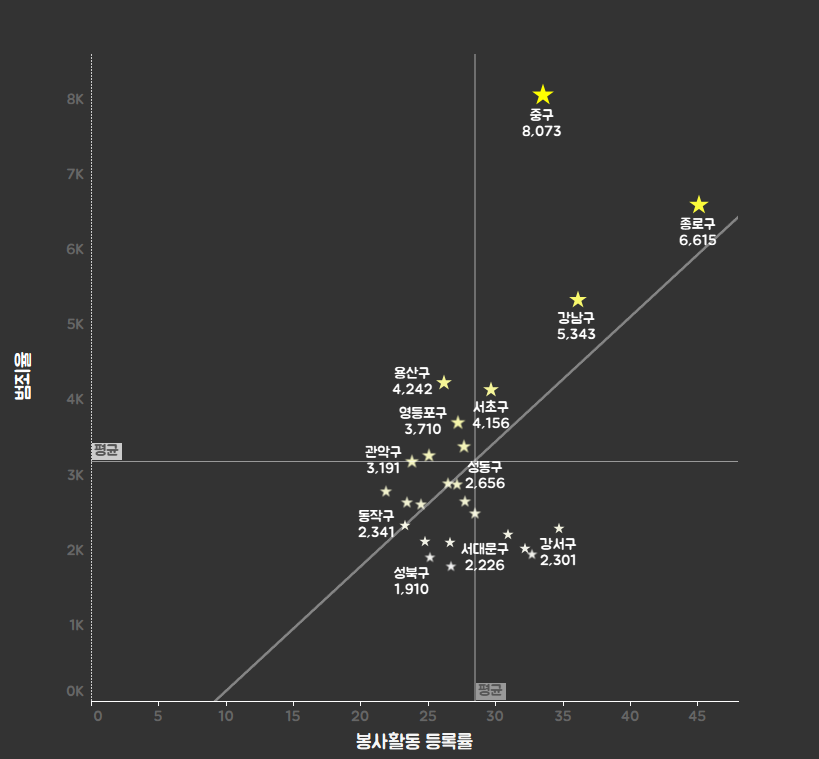

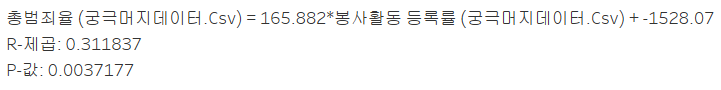

봉사활동 등록률과 총범죄율 간에 양의 상관관계(R² = 0.3118, p = 0.0037)가 관측됐다.
이는 일반적인 기대(봉사활동 참여가 범죄 예방에 기여할 것이라는 가설)와는 상반되는 결과를 보여줬다.

#### 생각해 봐야 할 점
- 봉사활동 등록률이 높기 때문에 범죄율이 높은 것이 아니라, 다른 요인이 이 둘에 영향을 미쳤을 가능성이 있다.
- 봉사활동 등록률은 활동의 질이나 자발성을 반영하지 않으며, 학생의 의무 활동이나 행정적 등록만으로 수치가 높게 나타날 수도 있다.


# 기타 (이혼율,실업률)

## 이혼율과 범죄율

이혼율이 높다면 가족 구조를 붕괴시켜 사회적불안율이 높을 것이다.
이혼율이 높다면 범죄율이 높을 것이다라는 가설

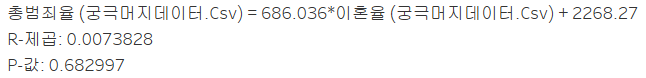

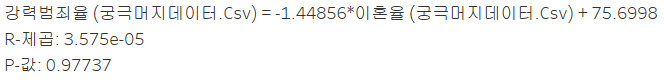

두 회귀식 모두 p-value가 0.05를 훨씬 초과하며, 결정계수도 거의 0에 가까워 설명력이 매우 낮기 때문에
통계적으로 유의하지 않으며, 실제 해석에 주의가 필요하다.


## 실업률과 범죄율

### 실업률

자치구의 실업률이 높을수록 경제적 불안정성과 사회적 소외가 심화되며, 이는 생계형 범죄 또는 사회 불만에 기인한 범죄 발생률의 증가로 이어질 가능성이 있다. 따라서 실업률이 높은 지역일수록 범죄율 또한 높을 것이다

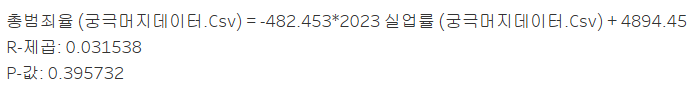

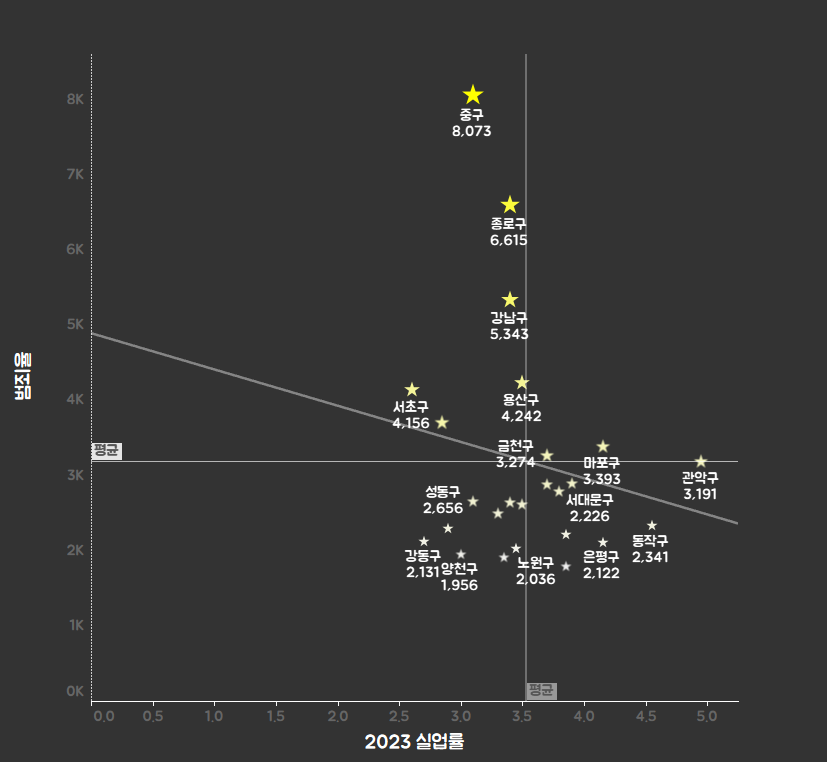

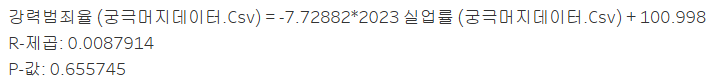

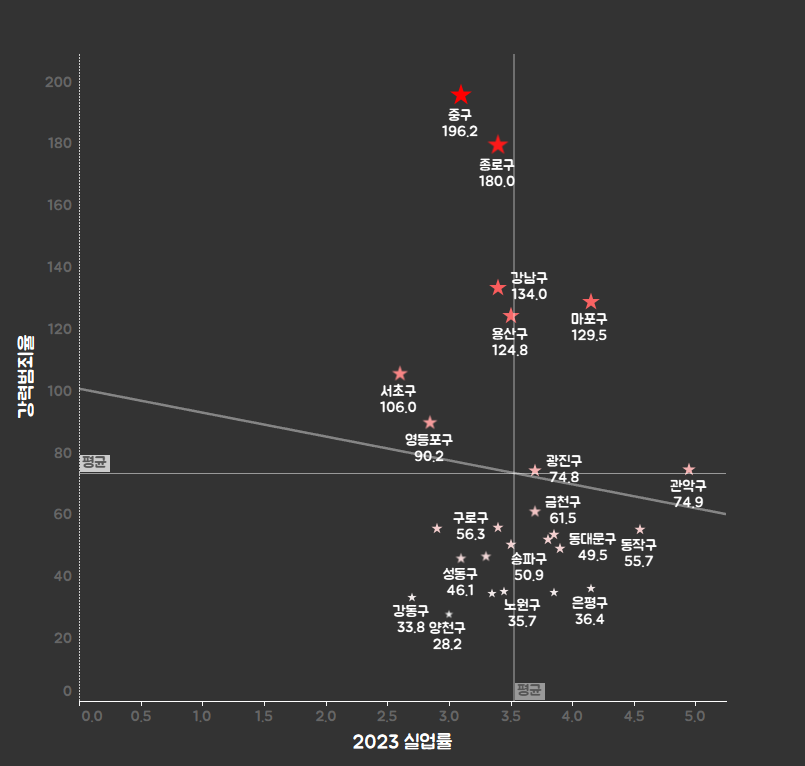

두 회귀식 모두 p-value가 0.05를 훨씬 초과하며, 결정계수도 거의 0에 가까워 설명력이 매우 낮다
실업율 역시 가정과 달리 본 분석에서 서울시 자치구의 범죄율을 설명하는 유효한 변수로 보기 어렵다

#### Thinking


- 데이터의 한계: 통계청 기준 실업률은 '구직활동을 하지 않는 비경제활동인구'를 포함하지 않으며, 실제 체감 실업률이나 불안정 고용 상태를 반영하지 못할 수 있다.
- 실업률의 범위가 좁다: 서울 자치구 간 실업률 차이가 작아, 범죄율 변화에 충분한 설명력을 가지기 어렵다 -> 이 점은 실업률을 0~1사이로 정규화한 데이터에서도 통계적 유의성을 확인할 수 없었다. 

# 📊 변수별 범죄율 회귀 분석 결과 요약



| 변수 | 종속변수 | 분석방법 | R² | p-value | 인사이트 요약 |
|------|----------|----------|-----|---------|----------------|
| **1인가구 비율** | 범죄율 | 지수 | 0.1626 | 0.0456 | 1인 가구 비율이 특정 임계점(예: 40% 이상)을 넘을 때, 범죄율이 급증할 수 있다는 점을 보여주며 정책적 개입 필요성을 보여준다. |
|  | 강력범죄율 | 지수 | 0.2241 | 0.0168 | - |
| **외국인 비율** | 범죄율 | 3차 다항회귀 | 0.7546 | 0.0001 | 외국인 비율이 높을수록 (특히 6% 이상) 총범죄율과 강력범죄율 모두 급격히 상승한다. 중구, 종로구, 용산구는 정책적 치안 강화 대상이 되어야 할 것이다. 강남구·서초구는 외국인 변수로 설명되지 않는 이상치이며 유흥업소, 고소득층 대상 범죄, 야간 활동 밀도 등 다른 변수가 필요하다. 마포구는 외국인 비율이 중간이지만 지역 특성상 외국인 상주 인구보다 유동 외국인의 영향이 클 가능성이 있다. |
|  | 강력범죄율 | 3차 다항회귀 | 0.6365 | 0.0001 | - |
| **중학교 학업중단율** | 범죄율 | 지수 | 0.3842 | 0.0009 | 강력범죄율도 전체 범죄율과 유사한 정도로 설명된다는 점에서 학업중단율은 전반적인 범죄 발생에 구조적 영향을 주는 변수일 수 있다. 이는 청소년기 이탈의 결과가 단순한 교육 손실이 아니라 사회 전반의 위험으로 확장될 수 있음을 보여준다. |
|  | 강력범죄율 | 지수 | 0.3938 | 0.0007 | - |
| **고등학교 학업중단율** | 범죄율 | 단순회귀 | 0.3157 | 0.0034 | 학업중단 예방 정책은 단순히 교육 문제가 아니라 공공안전 강화 정책의 일부로 간주될 수 있다. 하지만 고등학교 학업중단율의 결정계수가 0.3~0.37 수준이므로, 다른 변수들(예: 외국인 비율, 실업률 등)을 함께 고려하는 다중회귀 모델 또는 종합 지표가 필요하다. |
|  | 강력범죄율 | 단순회귀 | 0.3689 | 0.0012 | - |
| **우울감 경험률** | 범죄율 | 지수 | 0.1547 | 0.2253 | 우울감 경험률이 높다고 해서 강력범죄율이나 총범죄율이 높아지는 경향은 없었다. 오히려 우울감이 높으면 범죄율이 떨어지는 약한 음의 상관을 보여주었는데 R제곱의 값도 너무 낮으며 p-value가 너무 높아 통계적으로도 의미 없었다. 이 변수(우울감 경험률)는 현재 범죄 발생을 설명하거나 예측하는 데에 적절하지 않은 것 같다. |
|  | 강력범죄율 | 지수 | 0.0632 | 0.0517 | - |
| **자살률** | 범죄율 | 단순회귀 | 0.0366 | 0.359 | 매우 약한 상관, 통계적으로 유의하지 않다. |
|  | 강력범죄율 | 단순회귀 | 0.007 | 0.689 | - |
| **봉사활동 등록률** | 범죄율 | 단순회귀 | 0.3118 | 0.0037 | 봉사활동 등록률이 높기 때문에 범죄율이 높은 것이 아니라, 다른 요인이 이 둘에 영향을 미쳤을 가능성이 있다. 봉사활동 등록률은 활동의 질이나 자발성을 반영하지 않으며, 학생의 의무 활동이나 행정적 등록만으로 수치가 높게 나타날 수도 있다. |
|  | 강력범죄율 | 단순회귀 | 0.3073 | 0.004 | - |
| **이혼율** | 범죄율 | 단순회귀 | 0.0073 | 0.6829 | 이혼율은 본 분석에서 서울시 자치구의 범죄율을 설명하는 유효한 변수로 보기 어렵다. |
|  | 강력범죄율 | 단순회귀 | 0.0000358 | 0.9773 | - |
| **실업률** | 범죄율 | 단순회귀 | 0.0315 | 0.3957 | 두 회귀식 모두 p-value가 0.05를 훨씬 초과하며, 결정계수도 거의 0에 가까워 설명력이 매우 낮다. 실업율 역시 가정과 달리 본 분석에서 서울시 자치구의 범죄율을 설명하는 유효한 변수로 보기 어렵다. |
|  | 강력범죄율 | 단순회귀 | 0.0087 | 0.6557 | - |


##### p-value, R-squared 시각화

In [34]:
PnR_data = {
    '변수': ['1인가구 비율', '외국인 비율', '중학교 학업중단율', '고등학교 학업중단율',
           '우울감 경험률', '자살률', '봉사활동 등록률', '이혼율', '실업률'],
    'R²(총범죄율)': [0.1626, 0.7546, 0.3842, 0.3157, 0.1547, 0.0366, 0.3118, 0.0073, 0.0315],
    'p-value(총범죄율)': [0.0456, 0.0001, 0.0009, 0.0034, 0.2253, 0.359, 0.0037, 0.6829, 0.3957],
    'R²(강력범죄율)': [0.2241, 0.6365, 0.3938, 0.3689, 0.0632, 0.007, 0.3073, 0.0000358, 0.0087],
    'p-value(강력범죄율)': [0.0168, 0.0001, 0.0007, 0.0012, 0.0517, 0.689, 0.004, 0.9773, 0.6557],
}

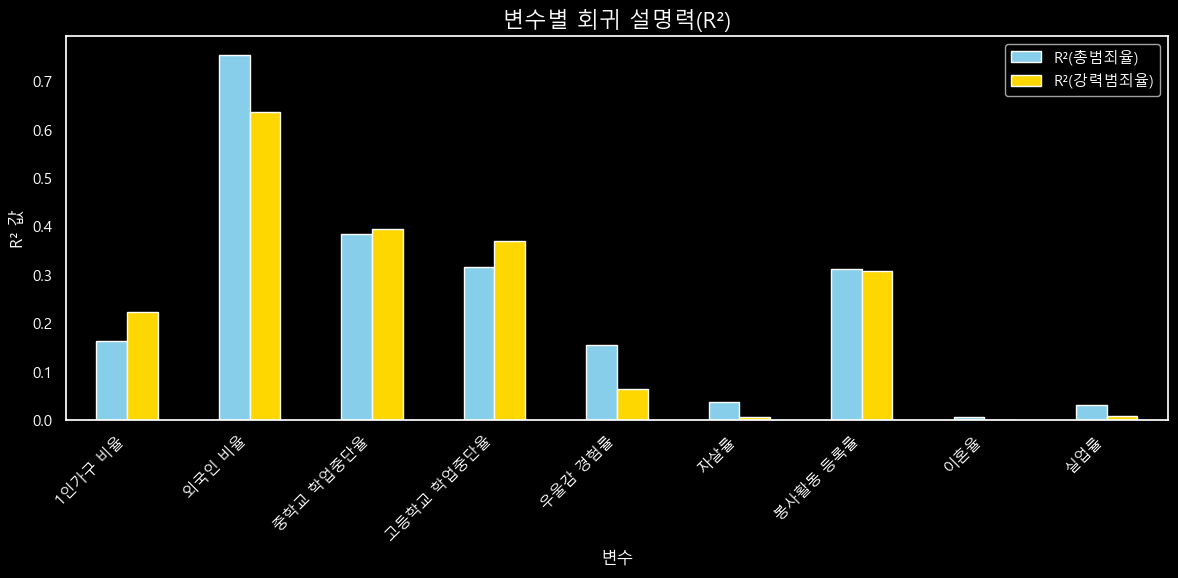

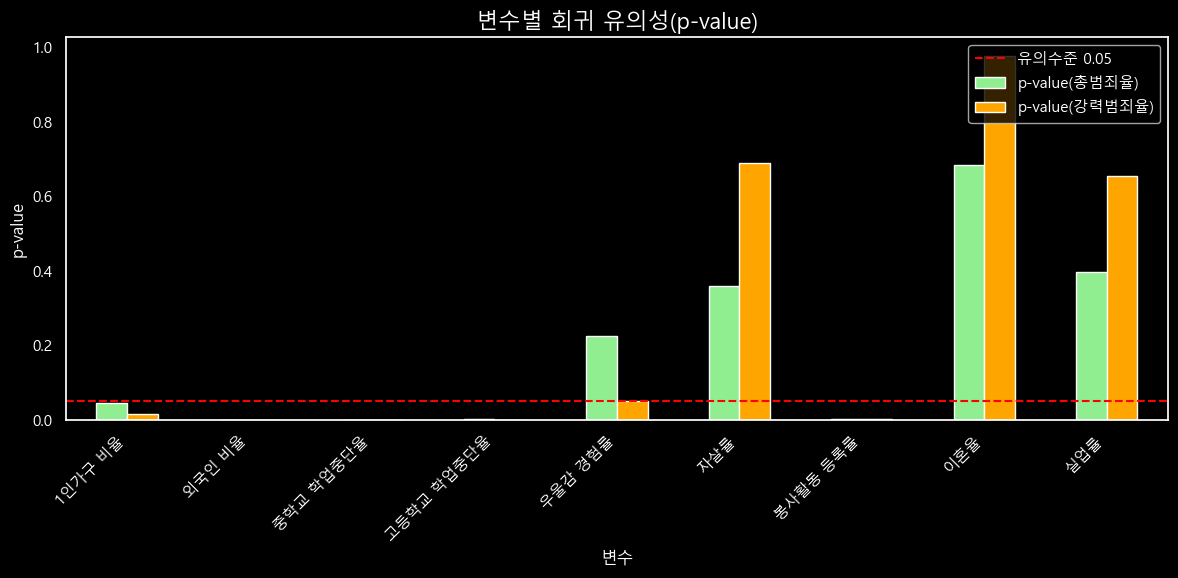

In [38]:
PnR_df = pd.DataFrame(PnR_data)
PnR_df.set_index('변수', inplace=True)

# 다크테마 적용
plt.style.use('dark_background')

# 2. R² 시각화
PnR_df[['R²(총범죄율)', 'R²(강력범죄율)']].plot(kind='bar', figsize=(12, 6), color=['skyblue', 'gold'])
plt.title('변수별 회귀 설명력(R²)', fontsize=16, color='white')
plt.ylabel('R² 값', color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

# 3. p-value 시각화
PnR_df[['p-value(총범죄율)', 'p-value(강력범죄율)']].plot(kind='bar', figsize=(12, 6), color=['lightgreen', 'orange'])
plt.axhline(y=0.05, color='red', linestyle='--', label='유의수준 0.05')
plt.title('변수별 회귀 유의성(p-value)', fontsize=16, color='white')
plt.ylabel('p-value', color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

##### 히트맵 시각화

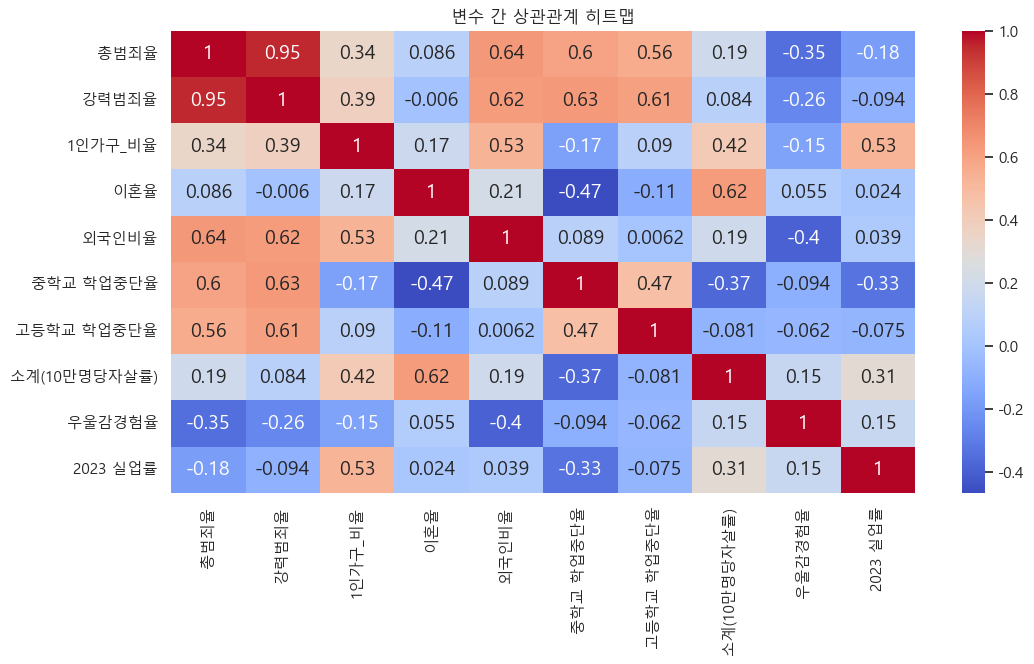

In [16]:
### 단변량분석 히트맵 시각화
corr = merged10_df[['총범죄율','강력범죄율','1인가구_비율','이혼율','외국인비율','중학교 학업중단율','고등학교 학업중단율','소계(10만명당자살률)','우울감경험율','2023 실업률']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("변수 간 상관관계 히트맵")
plt.show()

# 다변량분석 

In [8]:
# 통계분석 라이브러리리
import statsmodels.api as sm

### 데이터의 단위가 다 달라서 정규화한다

In [9]:
# 정규화 라이브러리
from sklearn.preprocessing import StandardScaler

In [10]:
# 데이터는 merged10_df를 가져와서 copy해준 것을 사용한다.
scale_df = merged10_df.copy()

### 총범죄율과 다변량분석

In [11]:
col_names = ['이혼율', '1인가구_비율','중학교 학업중단율','고등학교 학업중단율','소계(10만명당자살률)','우울감경험율','2023 실업률','외국인비율']

# 독립변수(X)와 종속변수(y) 분리
X = scale_df[col_names]
y = scale_df['총범죄율']

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 다시 DataFrame으로 변환
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 상수항 추가
X_scaled = sm.add_constant(X_scaled)

# 다변량량회귀분석
model = sm.OLS(y, X_scaled).fit()

# 결과추가
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   총범죄율   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     22.73
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           2.41e-07
Time:                        19:22:05   Log-Likelihood:                -186.67
No. Observations:                  25   AIC:                             391.3
Df Residuals:                      16   BIC:                             402.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3193.3183    105.820     30.177   

Adj. R-squared: 0.879, F-statistic: 22.73 / Prob(F-statistic): 2.41e-07
이혼율, 1인가구비율, 우울감경험율, 실업률 유의하지 않다

### 강력범죄율과 다변량분석

In [12]:
# 독립변수(X)와 종속변수(y) 분리
X = scale_df[col_names]
y = scale_df['강력범죄율']

# 정규화
scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)

# 다시 DataFrame으로 변환
X_scaled2 = pd.DataFrame(X_scaled2, columns=X.columns)

# 상수항 추가
X_scaled2 = sm.add_constant(X_scaled2)

# 다변량량회귀분석
model2 = sm.OLS(y, X_scaled2).fit()

# 결과추가
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  강력범죄율   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     17.67
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.42e-06
Time:                        19:22:06   Log-Likelihood:                -102.16
No. Observations:                  25   AIC:                             222.3
Df Residuals:                      16   BIC:                             233.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           73.7466      3.601     20.482   

Adj. R-squared: : 0.847, Prob (F-statistic): 17.67/1.42e-06
- 이혼율, 1인가구_비율, 자살률, 우울감경험율, 실업률 유의미하지 않다

### 다변량분석 영향력 순서 정리

- 총범죄율
1. 중학교 학업중단율
2. 	외국인비율
3. 고등학교 학업중단율
4. 자살률

- 강력범죄율
1. 중학교 학업중단율
2. 외국인비율
3. 고등학교 학업중단율


자살률은 총범죄에는 영향있지만 강력범죄에는 영향 없음

- 보면 회귀계수(총범죄율) > 회귀계수수(강력범죄율)인데 
예를 들면 총범죄율: 3000~4000 범위의 수치, 강력범죄율: 70~100 정도의 수치여서 그렇다. 
- 총범죄율은 더 폭넓은 사회 문제를 반영하고,
강력범죄율은 교육 문제와 외국인 비율 중심의 영향에 집중되어있다.

## 다변량분석 결과 정리

##### 다변량회귀분석 시각화

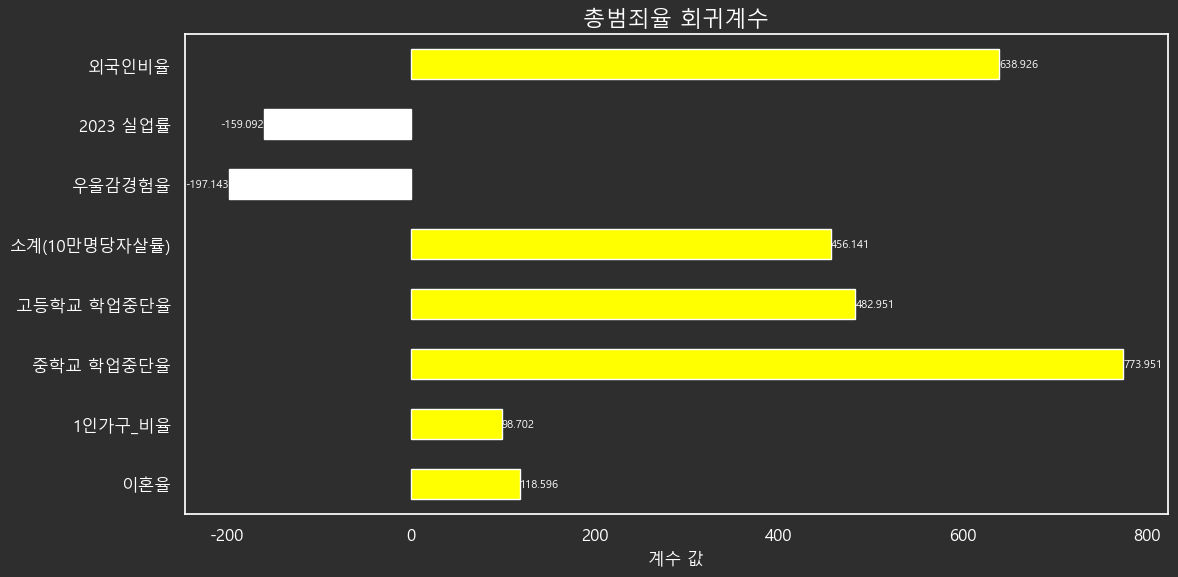

In [ ]:
# 다변량분석 시각화
# 회귀계수 추출 (const 제외)
coefs = model.params[1:]

# 색상 지정: 양수는 노란색, 음수는 흰색
colors = ['yellow' if coef > 0 else 'white' for coef in coefs]

# 다크 배경 스타일
plt.style.use('dark_background')
fig, ax = plt.subplots()

# 막대그래프 그리기
bars = coefs.plot(kind='barh', ax=ax, color=colors, edgecolor='white')

# 제목 및 라벨 설정
ax.set_title('총범죄율 회귀계수', fontsize=16, color='white')
ax.set_xlabel('계수 값', fontsize=12, color='white')
ax.tick_params(colors='white', labelsize=12)

# 배경색 설정
fig.patch.set_facecolor('#2E2E2E')
ax.set_facecolor('#2E2E2E')

# 그리드 제거
ax.grid(False)

# 각 막대 위에 회귀계수 표시
for i, (idx, coef) in enumerate(coefs.items()):
    ax.text(coef + (0.01 if coef > 0 else -0.01), i, f'{coef:.3f}',
            va='center', ha='left' if coef > 0 else 'right',
            color='white', fontsize=8)

plt.tight_layout()
plt.show()

### 설명

    본 회귀모델은 Adj R²=0.87.9로 총범죄율의 약 88%를 설명하며, 다중 변수의 복합적인 영향이 범죄율에 강한 설명력을 제공함을 보여준다
    중학교 학업중단율, 외국인비율, 고등학교 학업중단율, 자살률은 통계적으로 유의미한 변수로 확인되었고 이들은 총범죄율 증가와 밀접한 양의 상관관계를 갖는다.

- 중학교 학업중단율의 경우 해당 비율이 1% 증가할 때 총범죄율이 약 774건 증가하는 것으로 분석되었다. 
- 그 다음으로는 외국인 비율과 고등학교 학업중단율이 유의한 영향력을 보였고 각각 1% 증가할 때 약 639건, 483건의 증가한다.
- 이로 보아, 교육 탈락자 증가와 외국인 밀집도, 자살률 등 사회적 불안 요소가 복합적으로 작용하여 범죄율을 상승시키는 경향이 있음이 나타났다.

따라서 향후 범죄 예방 정책 수립 시, 단순한 치안 강화보다 다차원적 접근이 필요하다는 정책적 시사점을 도출할 수 있다.


- 교육 탈락자의 경우 출결, 성적, 상담이력, 가정형편 등을 기반으로 위험군을 식별하는 AI시스템을 도입해도 좋을 듯 하고 학업 중단 이후 지역사회 멘토링 및 학교 밖 청소년 전담 센터를 확대하여 지역사회에서 고립되지 않게끔 해야한다.


- 외국인 비율은 단변량 분석과 연결지어 생각해보면 전까지 완만하거나 감소하는 추세이다가 6퍼센트부터 급격히 증가하는 모습을 보여줬다. 이는 지역사회 수용 한계, 외국인 커뮤니티의 폐쇄성, 갈등 등이 누적되어 범죄 발생 조건이 폭발적으로 증가를 원인으로 생각해 볼 수 있다. 
따라서 6%이상 자치구를 우선시해서 외국인 커뮤니티 지원센터 설치를 추천할 수 있다. 

- 자살률의 경우 1인 가구 밀집지역 및 청년층 대상 정신건강 클리닉 파견 등 정신건강 취약계층에 대한 조기개입 및 지역사회 기반 돌봄을 강화해야한다. 

## VIF 확인

In [39]:
# 라이브러리 설치
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [41]:
# 없이 정규화
X_scaled_vif = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["변수"] = X_scaled_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])]

# 출력
print(vif_df.sort_values(by="VIF", ascending=False))

             변수       VIF
1       1인가구_비율  2.552900
0           이혼율  2.261128
2     중학교 학업중단율  2.168901
4  소계(10만명당자살률)  2.113413
7         외국인비율  2.043059
6      2023 실업률  1.813456
3    고등학교 학업중단율  1.451336
5        우울감경험율  1.316212


VIF 분석 결과, 모든 변수의 VIF 값이 5 미만으로 나타나 다중공선성 문제는 없는 것으로 판단된다.
따라서 본 회귀모형의 계수 추정은 안정적이라 볼 수 있다.
